In [ ]:
!pip install scikit-learn==1.1.3


  Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (32.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.
bigframes 1.35.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
!pip uninstall -y xgboost
!pip install xgboost==1.7.5


Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 9.9 MB/s eta 0:00:00


In [1]:
DATADIR = '/content/drive/MyDrive/fan/id_00'

In [ ]:
!pip install librosa numpy pandas seaborn matplotlib lime xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ba8d015e8ef5d6ff3a769c503150c657852fcf718f27209e89e6ce3e7c744fb5
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
feature_names = [
    'mean', 'median', 'variance', 'std_dev', 'skewness', 'kurt', 'zero_cross_rate',
    'num_waves', 'wave_duration', 'inst_freq', 'mobility', 'activity', 'complexity', 'k_complex', 'energy',
    'mean_freq', 'median_freq', 'variance_freq', 'std_dev_freq', 'skewness_freq', 'kurt_freq',
    'delta', 'theta', 'alpha', 'beta', 'gamma', 'sigma', 'zero_a', 'b_a'
]
assert len(feature_names) == 29, "Number of feature names does not match"

In [3]:
import os
import librosa
import numpy as np
from scipy.stats import skew, kurtosis

DATADIR = '/content/drive/MyDrive/fan/id_00'
CATEGORIES = ['abnormal', 'normal']

def augment_audio(audio):


    noise = np.random.normal(0, 0.005, len(audio))
    audio_noise = audio + noise


    try:
        audio_stretch = librosa.effects.time_stretch(audio, rate=0.8)
    except Exception as e:
        print("Time stretch error:", e)
        audio_stretch = audio


    try:
        audio_pitch = librosa.effects.pitch_shift(audio, sr=22050, n_steps=2)
    except Exception as e:
        print("Pitch shift error:", e)
        audio_pitch = audio

    return [audio_noise, audio_stretch, audio_pitch]

def extract_features_from_audio_advanced(audio, sr):


    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    mfccs_skew = skew(mfccs, axis=1)
    mfccs_kurtosis = kurtosis(mfccs, axis=1)


    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
    delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)


    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr), axis=1)


    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
    zcr_std = np.std(librosa.feature.zero_crossing_rate(audio))


    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)


    y_harmonic = librosa.effects.harmonic(audio)
    tonnetz = np.mean(librosa.feature.tonnetz(y=y_harmonic, sr=sr), axis=1)


    rmse = np.mean(librosa.feature.rms(y=audio))


    flatness = np.mean(librosa.feature.spectral_flatness(y=audio))


    ste = np.mean(audio ** 2)


    features = np.hstack([
        mfccs_mean,
        mfccs_std,
        mfccs_skew,
        mfccs_kurtosis,
        delta_mfccs_mean,
        delta2_mfccs_mean,
        spec_centroid,
        spec_rolloff,
        spec_contrast,
        zcr,
        zcr_std,
        chroma,
        tonnetz,
        rmse,
        flatness,
        ste
    ])
    return features

def extract_features_and_labels_with_augmentation(data_dir):

    features_list = []
    labels_list = []

    for category in CATEGORIES:
        category_path = os.path.join(data_dir, category)
        label = 1 if category == 'abnormal' else 0

        for file in os.listdir(category_path):
            if file.endswith('.wav'):
                file_path = os.path.join(category_path, file)
                try:

                    audio, sr = librosa.load(file_path, sr=22050)


                    features_original = extract_features_from_audio_advanced(audio, sr)
                    features_list.append(features_original)
                    labels_list.append(label)


                    augmented_audios = augment_audio(audio)
                    for aug_audio in augmented_audios:
                        features_aug = extract_features_from_audio_advanced(aug_audio, sr)
                        features_list.append(features_aug)
                        labels_list.append(label)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    return np.array(features_list), np.array(labels_list)

X_aug, y_aug = extract_features_and_labels_with_augmentation(DATADIR)

print("Augmented Features shape:", X_aug.shape)
print("Augmented Labels shape:", y_aug.shape)


Augmented Features shape: (620, 110)
Augmented Labels shape: (620,)


In [17]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Training set distribution:", dict(zip(unique_train, counts_train)))
print("Test set distribution:", dict(zip(unique_test, counts_test)))


Training set distribution: {0: 107, 1: 389}
Test set distribution: {0: 29, 1: 95}


In [18]:
np.save('/content/drive/MyDrive/fan/X_aug.npy', X_aug)
np.save('/content/drive/MyDrive/fan/y_aug.npy', y_aug)


In [19]:
import joblib

joblib.dump(best_model, '/content/drive/MyDrive/fan/best_xgb_model.pkl')


['/content/drive/MyDrive/fan/best_xgb_model.pkl']

In [20]:
results = {
    'Best Parameters': random_search.best_params_,
    'Best CV Accuracy': random_search.best_score_,
    'Test Accuracy': test_accuracy,
    'Classification Report': classification_report(y_test, y_pred)
}

import json
with open('/content/drive/MyDrive/fan/experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)


In [21]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnXGBClassifier(XGBClassifier, BaseEstimator, ClassifierMixin):
    def __sklearn_tags__(self):
        return {"binary_only": True}

xgb_model = SklearnXGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                 scale_pos_weight=scale_pos_weight)


In [22]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore", message="`use_label_encoder` is deprecated in 1.7.0.")

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

negative_count = np.sum(y_train == 0)
positive_count = np.sum(y_train == 1)
scale_pos_weight = negative_count / positive_count
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

param_grid_expanded = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    verbosity=1
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_expanded,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

print("Best Parameters (Randomized):", random_search.best_params_)
print("Best CV Accuracy (Randomized):", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Calculated scale_pos_weight: 0.28
Best Parameters (Randomized): {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV Accuracy (Randomized): 0.9274343434343434
Test Set Accuracy: 0.9193548387096774

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81        29
           1       0.93      0.97      0.95        95

    accuracy                           0.92       124
   macro avg       0.90      0.86      0.88       124
weighted avg       0.92      0.92      0.92       124



In [15]:
label = 1 if CATEGORIES == 'abnormal' else 0


In [16]:
sample_audio = X_test_scaled[0].reshape(1, -1)
predicted_prob = best_model.predict_proba(sample_audio)
print("Predicted probabilities:", predicted_prob)


Predicted probabilities: [[0.00340074 0.99659926]]


In [ ]:
from imblearn.over_sampling import SMOTE
print("SMOTE imported successfully!")


SMOTE imported successfully!


In [8]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Set Accuracy: 0.9193548387096774

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81        29
           1       0.93      0.97      0.95        95

    accuracy                           0.92       124
   macro avg       0.90      0.86      0.88       124
weighted avg       0.92      0.92      0.92       124



In [9]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9193548387096774


In [10]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

best_xgb = random_search.best_estimator_
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
svc_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('xgb', best_xgb), ('rf', rf_clf), ('svc', svc_clf)],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train)
y_pred_ensemble = voting_clf.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report
print("Ensemble Test Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("\nEnsemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))


Ensemble Test Accuracy: 0.9193548387096774

Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81        29
           1       0.92      0.98      0.95        95

    accuracy                           0.92       124
   macro avg       0.92      0.85      0.88       124
weighted avg       0.92      0.92      0.92       124



In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80        29
           1       0.91      0.99      0.95        95

    accuracy                           0.92       124
   macro avg       0.93      0.84      0.87       124
weighted avg       0.92      0.92      0.91       124

Confusion Matrix:
 [[20  9]
 [ 1 94]]


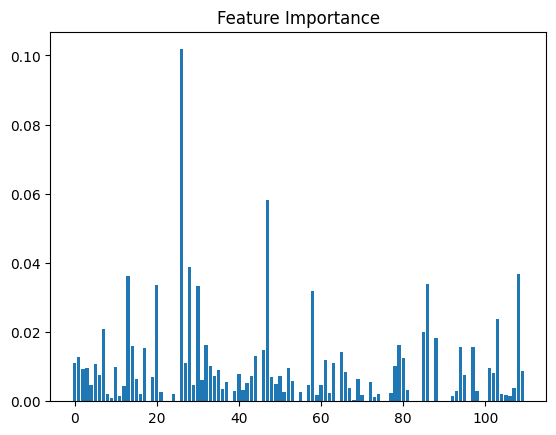

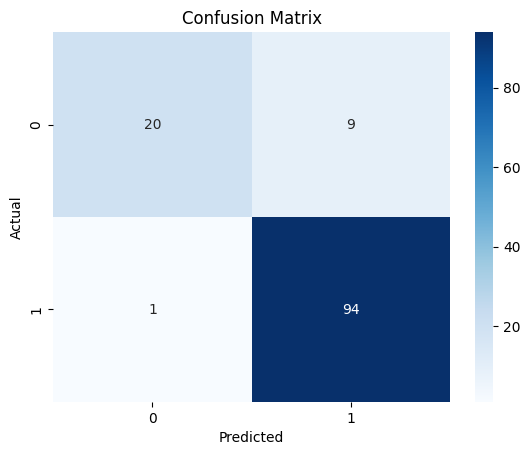

In [13]:
import matplotlib.pyplot as plt

plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.title("Feature Importance")
plt.show()

import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
